**<h2>Computing Water Potential Energy Surface Using Behler and Parinello Symmetry Functions** 

Importing relevant packages from PyTorch

In [1]:
"""
Created on Sat May 15 17:34:55 2021
@author: Katerina Karoni
"""
import torch                        # Torch is an open-source machine learning library, a scientific computing framework,
                                       #and a script language
import torch.nn as nn
import torch.nn.functional as F     # Convolution Functions
import torch.optim as optim         # Package implementing various optimization algorithms
import matplotlib.pyplot as plt
from torchvision import datasets, transforms  #The torchvision package consists of popular datasets, model 
                                              #architectures, and common image transformations for computer vision
from torch.utils.data import DataLoader, TensorDataset       #Data loading utility class
from torch import Tensor
import pandas as pd

import numpy as np
import random
import os
import ase
from ase import Atoms
from ase.io import read

Loading the data (energies and geometries) for 1000 water molecule configurations in .xyz form

In [2]:
energies = np.genfromtxt('./water/energies.txt')
print("Energies file has",np.shape(energies),"entries")
#geometry_data =  read('./water/structures.xyz',index=':')
#print("Geometry file has",np.shape(geometry_data),"entries")
#print(geometry_data[0])
#geometry_data = np.array(geometry_data)

Energies file has (1000,) entries


In [3]:
# see https://education.molssi.org/python-data-analysis/01-numpy-arrays/index.html
#https://stackoverflow.com/questions/23353585/got-1-columns-instead-of-error-in-numpy

file_location = os.path.join('water', 'structures.xyz')
xyz_file = np.genfromtxt(fname=file_location, skip_header=2, dtype='unicode',invalid_raise = False)
# where invalid_raise = False was used to skip all lines in the xyz file that only have one column
symbols = xyz_file[:,0]
coordinates = (xyz_file[:,1:-1])
coordinates = coordinates.astype(np.float)

#print(symbols)
#print(coordinates)

<ipython-input-3-c38e52de7b08>:5: ConversionWarning: Some errors were detected !
    Line #6 (got 1 columns instead of 5)
    Line #11 (got 1 columns instead of 5)
    Line #16 (got 1 columns instead of 5)
    Line #21 (got 1 columns instead of 5)
    Line #26 (got 1 columns instead of 5)
    Line #31 (got 1 columns instead of 5)
    Line #36 (got 1 columns instead of 5)
    Line #41 (got 1 columns instead of 5)
    Line #46 (got 1 columns instead of 5)
    Line #51 (got 1 columns instead of 5)
    Line #56 (got 1 columns instead of 5)
    Line #61 (got 1 columns instead of 5)
    Line #66 (got 1 columns instead of 5)
    Line #71 (got 1 columns instead of 5)
    Line #76 (got 1 columns instead of 5)
    Line #81 (got 1 columns instead of 5)
    Line #86 (got 1 columns instead of 5)
    Line #91 (got 1 columns instead of 5)
    Line #96 (got 1 columns instead of 5)
    Line #101 (got 1 columns instead of 5)
    Line #106 (got 1 columns instead of 5)
    Line #111 (got 1 columns instead

In [4]:
## Alternatively loading the data in .npy form
# # The data was downloaded from http://www.quantum-machine.org/datasets/ (Densities dataset--> water.zip)
# # The data includes energies, densities and structure for water molecules
# #For each dataset, structures are given in with positions in Bohr and the energies are given in kcal/mol 
# energy_data = np.load('./water_102/dft_energies.npy')
# print("Energies file has",np.shape(energy_data),"entries")
# geometry_data =  np.load('./water-2/water_102/structures.npy')
# print("Geometry file has",np.shape(geometry_data),"entries")
# print(type(energy_data))
# print(type(geometry_data))

In [5]:
print(np.shape(coordinates))
print(type(coordinates))
print(coordinates[0])
print(coordinates[1])
print(coordinates[2])

print('gfjkhgfjhgfkgh')
print(coordinates[3])
print(coordinates[4])
print(coordinates[5])

print(energies[0])
# There is 1000 water molecules and each of them consists of 3 atoms, so we have 3000 atoms in total and each
# of them has 3 coordinates.
# Thus the coordinates array has 3000 lines, each of them corresponding to one atom (the first three lines
# correspopnd to the first water molecule) and 3 columns corresponding to the x, y and z coordinates respectively.

(3000, 3)
<class 'numpy.ndarray'>
[0.         0.769767   0.55746937]
[ 0.         -0.71017975  0.50340914]
[ 0.         -0.0037242  -0.06630491]
gfjkhgfjhgfkgh
[0.         0.77715107 0.59586089]
[ 0.         -0.77642641  0.59515778]
[ 0.000000e+00 -4.529000e-05 -7.443867e-02]
-13815.2523726009


In [6]:
print(coordinates)

[[ 0.          0.769767    0.55746937]
 [ 0.         -0.71017975  0.50340914]
 [ 0.         -0.0037242  -0.06630491]
 ...
 [ 0.          0.81441381  0.59863567]
 [ 0.         -0.76145415  0.54978922]
 [ 0.         -0.00330998 -0.07177656]]


**<h2>Cutoff Function** 
    $$f_c(R_{ij}) = 
    \begin{cases}
        0.5 \times \big[\cos\big(\frac{\pi R_{ij}}{R_c}\big)+1\big]  & \text{for } R_{ij} \leq R_c\\
        0  & \text{for } R_{ij} > R_c
    \end{cases}
    $$
    
In the Behler and Parinello paper the Cutoff radius $R_c$ was taken to be $6$  Ångströms, or 11.3384 Bohr radii. (Remember, 1 Ångström is $10^{-10}$m)

In [7]:
def fc(R,Rc):
    if R <= Rc:
        fcutoff = 0.5 * (np.cos(np.pi*R/Rc)+1)
    else:
        fcutoff = 0
    return fcutoff

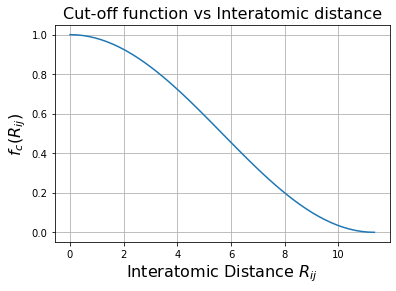

In [8]:
# Plotting fc as a function of interatomic distance Rij

Rc  = 11.3384 # Bohr

Rij     = np.linspace(0,Rc)
fcutoff = np.zeros(np.size(Rij))

for i in range(np.size(Rij)):
    fcutoff[i] = fc(Rij[i],Rc)

plt.plot(Rij,fcutoff)
plt.title('Cut-off function vs Interatomic distance', fontsize=16)
plt.xlabel('Interatomic Distance $R_{ij}$', fontsize=16)
plt.ylabel('$f_c(R_{ij})$', fontsize=16)
plt.grid()

**<h2>Pairwise Distances**

$$Dp = \begin{bmatrix} R_{00} & R_{01} & R_{02} \\ R_{10} & R_{11} & R_{12} \\ R_{20} & R_{21} & R_{22} \end{bmatrix} = \begin{bmatrix} 0 & R_{01} & R_{02} \\ R_{01} & 0 & R_{12} \\ R_{02} & R_{12} & 0 \end{bmatrix} $$

In [9]:
i = 0                                # i-th water molecule
N = 3                                # 3 atoms per molecule
coord = coordinates[N*i:N*(i+1),:]  # Let's take the coordinates of the ith water molecule in our dataset and compute
                                     # pairwise distances between all of its 3 atom
    
def pairwise_distances(coord):                       # we pass in the coordinates of the 3 atoms in the water molecule
    N = len(coord)
    pairwise_dist_matrix = np.zeros((N,N))       # Initialise the matrix
    for i in range(0,N-1):
#        print('i=',i)
        for j in range(i+1,N):
#            print(j)
#            pairwise_dist_matrix[i][j] = \
#            np.sqrt(  (coord[i][0] - coord[j][0] )**2 + (coord[i][1] - coord[j][1] )**2 +(coord[i][2] - coord[j][2] )**2   )
            pairwise_dist_matrix[i][j] =  np.sqrt(sum( (coord[i,:] - coord[j,:])**2 ))
            pairwise_dist_matrix[j][i] = pairwise_dist_matrix[i][j]
            print(pairwise_dist_matrix[i][j])
    return pairwise_dist_matrix

Dp = pairwise_distances(coord)
print(Dp)



1.4809337903171818
0.9936714692829608
0.9075536033167435
[[0.         1.48093379 0.99367147]
 [1.48093379 0.         0.9075536 ]
 [0.99367147 0.9075536  0.        ]]


**<h2>From Cartesian to Generalised Coordinates**

**<h3>Radial Symmetry Functions**
    
<h3>$$G_i^1 = \sum_{j \neq i}^{\text{all}} e^{-\eta (R_{ij}-R_s)^2} f_c (R_{ij})$$

In [10]:
heta = 0.1
Rs   = 0
N    = len(coord)


def radial_BP_symm_func(Dp,N,heta,Rs):
    G_mu1 = np.zeros(len(Dp))           # since we are dealing with water molecules the dimension of G will be 3 (H,H,O)
    for i in range(N):                 # to avoid using an if statement (if i not equal j), break the sum in two
        for j in range(0,i):
            G_mu1[i] = G_mu1[i] + np.exp(-heta*(Dp[i][j]-Rs)**2)* fc(Dp[i][j],Rc) 
        for j in range(i+1,N):
            G_mu1[i] = G_mu1[i] +  np.exp(-heta*(Dp[i][j]-Rs)**2)* fc(Dp[i][j],Rc) 
    return G_mu1

Gmu1 = radial_BP_symm_func(Dp,N,heta,Rs)
print(Gmu1)

[1.65865495 1.67618952 1.79537284]


**<h3> Angular Symmetry Functions**

$$G_i^2 = 2^{1-\zeta} \sum_{j,k \neq i}^{\text{all}} (1+\lambda \cos \theta_{ijk})^\zeta \times e^{-\eta (R_{ij}^2+R_{ik}^2+R_{jk}^2 )} f_c (R_{ij})f_c (R_{ik})f_c (R_{jk})$$
    
with parameters $\lambda = +1, -1$, $\eta$ and $\zeta$

In [11]:
lambdaa = 1     #1
zeta    = 0.2
heta    = 0.1

N = len(coord)

def angular_BP_symm_func(coord,Dp,N,heta,Rs,lambdaa,zeta):
    G_mu2 = np.zeros(len(Dp))           # since we are dealing with water molecules the dimension of G will be 3 (H,H,O)

    for i in range(N):                 # to avoid using an if statement (if i not equal j), break the sum in two
        for j in range(N):           
            for k in range(N):
                if j != i and k !=i:
                    R_vec_ij = coord[i,:] - coord[j,:]
                    R_vec_jk = coord[i,:] - coord[k,:]
                    cos_theta_ijk  = np.dot(R_vec_ij, R_vec_jk)/(Dp[i][j]*Dp[i][k])
                    G_mu2[i]   = G_mu2[i] + (  1 + lambdaa * cos_theta_ijk )**zeta  \
                                * np.exp( -heta * (Dp[i][j]**2 + Dp[i][k]**2 + Dp[j][k]**2) ) \
                                * fc(Dp[i][j],Rc) * fc(Dp[i][k],Rc) * fc(Dp[j][k],Rc)            
        G_mu2[i]   = 2**(1-zeta) * G_mu2[i] 
    return G_mu2

Gmu2 = angular_BP_symm_func(coord,Dp,N,heta,Rs,lambdaa,zeta)
print(Gmu2)

[5.19473151 5.24520024 5.28298916]


In [12]:
np.cos(180)

-0.5984600690578581

**<h2>Training and Test Set**

In [13]:
N                    = 3           # number of atoms per molecule
number_of_features   = 20           # number of features (symmetry functions) for each atom (we create one radial)
                                   # and one angular, but can create more by vaying the parameters η, λ, ζ, Rs etc.

    
    
heta   = np.linspace(0.01, 4, num=number_of_features)
random.shuffle(heta)

Rs     = np.linspace(0, 1, num=number_of_features)
random.shuffle(Rs)

lambdaa = np.ones(number_of_features)
random.shuffle(lambdaa)

zeta    = np.linspace(0, 8, num=number_of_features)
random.shuffle(zeta)


# heta    = [0.01,  4.,    3.202, 1.606, 2.404, 0.808] 
# zeta    = [8.,  1.6, 3.2, 4.8, 6.4, 0. ]
# Rs      = [0.8, 0.4, 0.2, 1.,  0.,  0.6]
# lambdaa = [1., 1., 1., 1., 1., 1.]




data_size            = np.shape(energies)[0]        # We have 1000 water molecule conformations
training_set_size    = data_size - 100



    
G = np.zeros((len(coordinates), number_of_features))  # we have 3000x2 features (2 symm funcs for ech of the 3000 atoms in the dataset)

for i in range(data_size):
    coord = coordinates[N*i:N*(i+1),:]
    Dp    = pairwise_distances(coord)
    for j in range(0,number_of_features,2):
        G[N*i:N*(i+1),j]   = radial_BP_symm_func(Dp,N,heta[j],Rs[j])     
        G[N*i:N*(i+1),j+1] = angular_BP_symm_func(coord,Dp,N,heta[j],Rs[j],lambdaa[j],zeta[j])
    
# Computing variance and mean on the training data only!
G_train = G[:training_set_size,:]
var  = np.var(G_train,axis=0)
mean = np.mean(G_train,axis=0)

G_norm = np.zeros((len(coordinates), number_of_features))
# normalize all data (training and test), using training set mean and variance
for i in range(np.shape(G)[0]):
    for j in range(np.shape(G)[1]):
        G_norm[i,j] = (G[i,j]-mean[j])/var[j]   


data_set = np.vsplit(G_norm,data_size)     # Going from a (3000,2) np.array to a (1000,3,2) list
#data_set = np.random.permutation(training_set)
data_set = torch.FloatTensor(data_set)          # Going from a (1000,3,2) list to a a (1000,3,2) tensor

# print(data_set[0])
# print(data_set[0][1][1])

labels = energies          # turning energies into a (1000) tensor


# Computing variance and mean on the training data only!
lab_train = labels[:training_set_size]
var_lab  = np.var(lab_train,axis=0)
mean_lab = np.mean(lab_train,axis=0)
print(mean_lab)

labels_norm = np.zeros((np.shape(labels)))
# normalize all data (training and test), using training set mean and variance
for i in range(np.shape(labels)[0]):
    labels_norm[i] = (labels[i]-mean_lab)/var_lab  
    
    
labels_norm = torch.FloatTensor(labels_norm)      
    
    
# Splitting the dataset into training and test set
training_set         = data_set[:training_set_size]
test_set             = data_set[training_set_size:]

train_labels         = labels_norm[:training_set_size]
test_labels          = labels_norm[training_set_size:]

# Dataset
dataset = TensorDataset(training_set, train_labels)
#print(dataset[0])

# Creating the batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=25,
                                           shuffle=False, num_workers=2, drop_last=False) # ?????

print(np.shape(training_set))

1.4809337903171818
0.9936714692829608
0.9075536033167435
1.5535776391049219
1.0263214321709564
1.0252448728694317
1.641368955251778
1.0296241445528371
0.9245425561246101
1.562310202650181
1.0444362369102793
0.9408131662300395
1.5534064631206874
1.0117901180626663
1.0059422892679348
1.4097927336451104
0.981488947698239
0.9698663397992994
1.5919719259635425
1.0457779476389586
1.0238150317336627
1.4460928508359974
0.9923289507886108
0.884325958533155
1.5898529914539519
1.055877732322894
0.9995253500458467
1.5580038885371763
1.026995739510787
0.9326169288303807
1.64450333465209
1.0430751892542738
0.9564843903217655
1.5484755704371989
1.0101019030778409
0.8980030723132179
1.534972856109294
1.0542232363755162
0.9130081322388126
1.4452059088962874
1.0511128942080972
0.8812115616889616
1.5039871588034366
1.0042258972723037
0.8787207649978057
1.4726051808003189
0.9759117438815379
0.8779145167183795
1.402078601872584
0.9698430808210092
0.9351833947496675
1.4235979309765876
0.9906884558655636
0.9

1.4958533307985287
1.0221897674221927
0.8801708857932625
1.5073404318449897
0.9954346731429243
0.9053877487811005
1.6879461229928094
1.0329187058369063
0.9826659556795618
1.556145581907922
1.0118185169521245
0.9078299901146193
1.561316742411757
1.0524112729799517
0.9209090093001352
1.4665940421510013
0.9808425936350222
0.9338041582861301
1.4992568274782745
1.0650133489910205
0.9357100258182879
1.44593219516878
1.002654930241362
0.9842065618768889
1.3852523304741347
0.9778173335894711
0.9108395269076578
1.61473358469588
1.0432208489078931
0.8747236676162726
1.3939908502066145
0.9513053016128954
0.9347496926579574
1.4786412233788682
0.9520465102030099
0.8946629683477847
1.4646471656479765
1.0641459523756298
0.8957030937498677
1.6260085803257667
1.0213196868133794
0.9656820700051714
1.4090372108599392
0.9298293964100707
0.8722847279513767
1.5282704678903805
1.00991712581757
0.8824578964462434
1.447801117251626
0.9875940109150331
0.9383455192661826
1.633637867447388
1.0558151074462676
0.92

1.4980962592739637
1.0657219996167888
0.9600794870409546
1.2944299012358822
0.8828241637578633
0.881305492224931
1.6632350665214224
1.033118192152689
0.9951710048263613
1.622394902890017
1.0636493679841552
0.8846767866085702
1.586275198062356
1.0550643252094398
0.9953363409550626
1.4969578070171659
1.0064103552097357
0.9670349275245715
1.6195739478097937
1.0045897005242808
0.968396047827692
1.5089237766324632
1.018488880575834
0.9130164170775609
1.4873166298341771
1.0537784143446904
0.9509021731569117
1.4572328170009192
0.9456277231913873
0.895446284505566
1.4644312422165613
1.0581237403650778
0.9339014554322776
1.5203222072620328
1.058727167434596
1.0406566788104517
1.4288879059340247
1.03512499481514
0.8928284481530189
1.483799839137243
0.9831439363527745
0.9648047898468316
1.6175559246020588
1.0566167524463514
0.8805711270374408
1.55599872199667
1.0136967946765818
1.0000653465796263
1.6301956601524867
1.0639846613977912
1.011451228532115
1.5365209438295049
0.9345380056226668
0.89242

1.5975028352220113
1.0211919217583532
0.9103811224731931
1.604780482596879
1.0242205767258699
0.9044825132858672
1.3844531841379975
0.9096874016819451
0.8878625006130606
1.4637920634443358
0.9382964650341575
0.9039808499044448
1.3986393493221685
1.024397795248976
0.9006401128967333
1.425269607724355
0.9332743815500215
0.8714414164737437
1.6396159884783708
1.0455524748975251
0.9951950234714156
1.5664405146652156
1.0082877721331316
0.8737872913950874
1.5292782359636725
1.0195285241747738
0.9218653010892787
1.526988321417722
0.9909948489705951
0.8940879070505092
1.446143541187612
0.9500660030897695
0.8848069564733074
1.5052669405544026
1.0306629741787512
0.8890429627688854
1.4607761785571793
0.9827180778325147
0.9764464519294097
1.6986107350892905
1.026431918583825
0.9866063231374088
1.3880295877406916
0.8797956238845609
0.8777854863214863
1.5231181114835408
0.9899255988019368
0.8857003941390096
1.4760141829270776
0.908710205286805
0.8924773849320761
1.4556758257313152
0.9604254997653306


1.6038518218830173
1.063367542560589
0.9257042402244118
1.6800808797329787
1.0583487089254064
1.0246669082257482
1.6465854682596526
1.0373003103199794
0.9593537467397191
1.6973580028981476
1.0552862118888133
1.0096612732041756
1.6355388469104766
1.0610387202979206
0.9464264836324733
1.5005347588965217
0.9103165378028225
0.8949546545914173
1.5549109015137452
1.0114303222696648
1.0084144246487756
1.4935760792871295
0.9849045482382012
0.886011490216791
1.3994449822615502
0.9534231492170598
0.9046443625763156
1.6230930133962214
1.048370109134751
0.8947553794316734
1.543821056017721
0.995025548644164
0.9007618587649382
1.7612956306664074
1.0670689840063883
1.0251992647528252
1.5514663286122152
1.0302393671022365
0.9531962152090282
1.5180705506091612
1.0312797455849643
1.0205287216371184
1.5353950551353852
0.9407598841653363
0.8854820135856
1.4126864408206843
1.0075953152644896
0.873776206138256
1.465075572580378
1.0144990440847197
1.0038933425477876
1.6262694365054426
1.0194779582698932
0.9

1.4897732765161076
0.9250000694353694
0.8790929218846355
1.6095125836998516
1.032010243848672
0.938640677003351
1.398467429048943
1.0129487328199023
0.8730773051188867
1.6010494319831516
1.0003582534844515
0.9562937877188883
1.4543927016569558
0.936808933307579
0.9111318607981578
1.3991898278334898
1.0035768131959335
0.9274897402788974
1.3587213344587308
0.9340130783896426
0.8878291620077572
1.5170762952489847
1.0351237280917185
0.8844807415397187
1.622899096891369
1.066062977933567
0.9540975316907621
1.5879029500630502
0.979815490974897
0.9563633827709347
1.501107714756661
0.9858177877538544
0.9017503133312397
1.359866303329431
0.9190265701516583
0.9002528380827357
1.5208215976475796
0.98479362463361
0.9266075579443543
1.5930471847909355
1.0236698757981488
0.9512111186458756
1.4417966767596178
1.0429130112138387
0.9351522518117811
1.579283085542821
1.028058494960882
0.9979261918265877
1.3240487009843807
0.9462293154427155
0.8719339161235996
1.429489177547735
0.9753559359370255
0.91115

1.483280887148162
1.065698480936326
0.964654426651193
1.579702914602594
1.0663594953233395
1.0396996303102528
1.5219105018172954
1.0652715038453147
0.8782157665788936
1.4364196991361498
1.0461844147745556
0.88042347195475
1.4513862290534767
1.0260860254541573
0.8964000458007252
1.532666498629559
1.0522466913249469
0.9323077939044888
1.5589325478470506
0.9597709371831505
0.8998091799401845
1.4584356295426133
0.9959949751677285
0.9855139159738076
1.6262578201343425
0.9980639434245268
0.9533906598111581
1.5933391578848177
1.0542807292139884
1.0265100486907441
1.60131873358559
1.0339940781654318
1.013268417535698
1.6674666311922537
1.053316352982641
0.9369901177553938
1.5903902265902048
1.0035054703741735
0.8970506238872803
1.4357802698407318
1.0266512398755423
0.9612244294459907
1.551200529900174
1.0233259156872705
0.9353719882864305
1.5035666325429755
1.045818184097252
1.0160731583342373
1.4899377361511401
0.9756856283111892
0.9211211235713489
1.627655784628275
1.0557412715446455
0.88033

In [14]:
print(G)

[[0.94011721 0.77829821 1.44344043 ... 0.01999619 0.87112445 0.1158069 ]
 [0.9995811  0.88641472 1.4803309  ... 0.04266943 0.95848254 0.18135498]
 [1.31439656 1.21935437 1.74117052 ... 0.06213325 1.40252565 0.27946167]
 ...
 [0.8459288  0.61544427 1.35899814 ... 0.01076776 0.74853903 0.07520604]
 [0.89953042 0.70742078 1.39482273 ... 0.02236074 0.82882568 0.11724208]
 [1.21981677 1.02123465 1.68039475 ... 0.03298874 1.26241196 0.18493328]]


In [15]:
a = np.array([[1.0,2.0],[3.0,4.0],[5.0,6.0]])
# for i in range(3):
#     a[i,0] = a[i,0]/(sum(a[:,0])/3)
# print(a)

b = (sum(a[:,0])/3)
print(b)
print(type(b))
a[0,0] = a[0,0]/b
print(a)

3.0
<class 'numpy.float64'>
[[0.33333333 2.        ]
 [3.         4.        ]
 [5.         6.        ]]


**<h2>Building Neural Network Architecture**

In [16]:
class Subnets(nn.Module):
    def __init__(self):
        super(Subnets, self).__init__()
        self.fc1 = nn.Linear(20, 10)        # where fc stands for fully connected 
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
#         self.fc6 = nn.Linear(6, 4)
#         self.fc7 = nn.Linear(4, 2)
#         self.fc8 = nn.Linear(2, 1)


    def forward(self, x,train = True):
        x = torch.tanh(self.fc1(x))           # Apply a tanh activation on fully connected layer 1 
        x = torch.tanh(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         x = torch.tanh(self.fc4(x))
#         x = torch.tanh(self.fc5(x))
#         x = torch.tanh(self.fc6(x))
#         x = torch.tanh(self.fc7(x))
        x = self.fc3(x)                   # Using a linear function (identity function) for the subnet output layers
        return x

class BPNN(nn.Module):
    def __init__(self):
        super(BPNN, self).__init__()
        self.network1 = Subnets()
        self.network2 = Subnets()
        self.network3 = Subnets()
        
#        self.fc_out = nn.Linear(3, 1)      # should this be defined here, given that we are not trying to optimise
        
    def forward(self, x1, x2, x3,train = True):
        x1 = self.network1(x1)
        x2 = self.network2(x2)
        x3 = self.network3(x3)
        
#         print(x1)
#         print(x2)
#         print(x3)
        
        x = torch.cat((x1, x2, x3), 0) 
#        x = self.fc_out(x)
        x = torch.sum(x)                   #??????????????????????????? try average pooling?
        x = torch.reshape(x,[1])
        return x

    
model = BPNN()
N = 1
x1, x2, x3 = training_set[0]
print('x1',x1)
print('x2',x2)
print('x3',x3)


output = model(x1, x2, x3)
print('output')
print(output)


# print(model)

# print('Network1')

# print('layer 1')
# print('weights')
# print(model.network1.fc1.weight)
# print('biases')
# print(model.network1.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network1.fc2.weight)
# print('biases')
# print(model.network1.fc2.bias)

# print('Network2')

# print('layer 1')
# print('weights')
# print(model.network2.fc1.weight)
# print('biases')
# print(model.network2.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network2.fc2.weight)
# print('biases')
# print(model.network2.fc2.bias)

# print('Network3')

# print('layer 1')
# print('weights')
# print(model.network3.fc1.weight)
# print('biases')
# print(model.network3.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network3.fc2.weight)
# print('biases')
# print(model.network3.fc2.bias)



x1 tensor([  -3.3669,   -2.6794,   -3.4957,   -0.8164,   -9.5576,  -52.3066,
          -3.4165,   -4.9550,   -2.0192, -484.8375,   -8.1867, -256.4972,
          -1.5849, -186.4589,   -1.8482, -135.9458,   -2.2246,  -38.0778,
          -2.6052,   -9.8786])
x2 tensor([-1.5537e+00, -4.1569e-01, -1.9123e+00,  1.3752e+00, -6.6221e-01,
         2.1518e+01, -1.3910e+00,  1.9488e-01, -1.0067e+00,  2.8188e+02,
         3.5793e-02,  1.4202e+02, -1.5373e+00,  9.9566e+01, -1.1600e+00,
         6.9494e+01, -1.0954e+00,  1.3931e+01, -1.2021e+00,  1.2635e+00])
x3 tensor([  8.0458,   6.5554,   9.2833,   5.3343,  17.9228,  77.6209,   7.6480,
         10.1241,   4.3637, 562.7095,  14.9666, 319.0089,   4.3268, 240.1537,
          4.2952, 181.4388,   4.9861,  58.5775,   5.9301,  17.9401])
output
tensor([-0.0576], grad_fn=<ViewBackward>)


In [17]:
# class simplenn(nn.Module):
#     def __init__(self):
#         super(simplenn, self).__init__()
#         self.fc1 = nn.Linear(2, 3)        # where fc stands for fully connected 
#         self.fc2 = nn.Linear(3, 1)        
   

#     def forward(self, x):
#         x = torch.tanh(self.fc1(x))           # Apply a tanh activation on fully connected layer 1 
#         x = self.fc2(x)                   # Using a linear function (identity function) for the subnet output layers
#         return x

# mod = simplenn()

# print(mod.fc1.weight)
# print(mod.fc1.bias)

# print(mod.fc2.weight)
# print(mod.fc2.bias)

In [18]:
# x1, x2, x3 = training_set[0]
# x1 = x1[:2]
# x2 = x2[:2]

# x1[0] = -18650
# x1[1] = 109075
# print('x1',x1)

# x2[0] = -6
# x2[1] = 7
# print('x2',x2)

# output1 = mod(x1)
# print('output1')
# print(output1)

# output2 = mod(x2)
# print('output2')
# print(output2)

In [19]:
x1, x2, x3 = training_set[0]
print('x1',x1)
print('x2',x2)
print('x3',x3)


output = model(x1, x2, x3)
print('output')
print(output)

x1 tensor([  -3.3669,   -2.6794,   -3.4957,   -0.8164,   -9.5576,  -52.3066,
          -3.4165,   -4.9550,   -2.0192, -484.8375,   -8.1867, -256.4972,
          -1.5849, -186.4589,   -1.8482, -135.9458,   -2.2246,  -38.0778,
          -2.6052,   -9.8786])
x2 tensor([-1.5537e+00, -4.1569e-01, -1.9123e+00,  1.3752e+00, -6.6221e-01,
         2.1518e+01, -1.3910e+00,  1.9488e-01, -1.0067e+00,  2.8188e+02,
         3.5793e-02,  1.4202e+02, -1.5373e+00,  9.9566e+01, -1.1600e+00,
         6.9494e+01, -1.0954e+00,  1.3931e+01, -1.2021e+00,  1.2635e+00])
x3 tensor([  8.0458,   6.5554,   9.2833,   5.3343,  17.9228,  77.6209,   7.6480,
         10.1241,   4.3637, 562.7095,  14.9666, 319.0089,   4.3268, 240.1537,
          4.2952, 181.4388,   4.9861,  58.5775,   5.9301,  17.9401])
output
tensor([-0.0576], grad_fn=<ViewBackward>)


In [20]:
## Manually compute neural Network output

# w11 = model.network1.fc1.weight
# b11 = model.network1.fc1.bias
# print(np.shape(w11))
# x1 = np.reshape(x1,(2,1))
# x1 = np.array(x1)
# print(np.shape(x1))

# w11 = w11.cpu().detach().numpy()
# b11 = b11.cpu().detach().numpy()
# #b11 = np.transpose(b11)
# b11 = np.reshape(b11,(3,1))
# print(np.shape(b11))
# print(type(x1))
# print(type(w11))

# a11 = np.matmul(w11,x1) + b11
# a11 = np.tanh(a11)
# print(a11)
# #print(torch.tensordot(w11,x1))


In [21]:
print('layer 1')
print('weights')
print(model.network1.fc1.weight)
print('biases')
print(model.network1.fc1.bias)

print('layer 2')
print('weights')
print(model.network1.fc2.weight)
print('biases')
print(model.network1.fc2.bias)

layer 1
weights
Parameter containing:
tensor([[-0.0767,  0.1162, -0.0293, -0.0024, -0.0759,  0.2108,  0.0159,  0.1640,
          0.0895, -0.0396,  0.0339,  0.1994,  0.1056, -0.1322, -0.0169, -0.0172,
          0.1570,  0.1106, -0.0036,  0.1732],
        [ 0.0625,  0.1281, -0.1736,  0.1375, -0.1028, -0.0405, -0.0381,  0.0583,
          0.1039, -0.1018,  0.1559, -0.1421,  0.0069, -0.0959,  0.0958,  0.1842,
         -0.2151, -0.1892,  0.1577,  0.0893],
        [-0.1498,  0.0088, -0.1616, -0.1947, -0.2171,  0.1426,  0.2182,  0.2200,
          0.1337, -0.1738, -0.0770, -0.1743,  0.1575, -0.0698,  0.0360,  0.2077,
          0.0186,  0.0501,  0.0462,  0.1930],
        [-0.0144, -0.1148,  0.2065,  0.1097, -0.1476, -0.0114,  0.1569, -0.1213,
         -0.2101,  0.0546,  0.0444,  0.2202, -0.0645, -0.1021, -0.1016, -0.1810,
         -0.1953, -0.1505, -0.0650, -0.0320],
        [ 0.0264, -0.1856,  0.0253, -0.0507,  0.1399,  0.1035, -0.1313, -0.1046,
         -0.0735, -0.0945,  0.0649, -0.1370, -0.1

**<h2>Training the Neural Network**

In [22]:
net = BPNN()

In [23]:

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
#torch.optim.LBFGS(net.parameters(), lr=0.001, max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, line_search_fn=None)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.1)
nepochs = 2000

train_loss = np.zeros(nepochs)
test_loss = np.zeros(nepochs)

train_acc = np.zeros(nepochs)
test_acc = np.zeros(nepochs)

#===========================================================================
for epoch in range(nepochs):          # loop over the dataset multiple times
#===========================================================================
    
    running_loss = 0.0                #  Initialise losses at the start of each epoch 
    epoch_train_loss = 0.0             
    epoch_test_loss = 0.0
    
    
    counter = 0                               # ranges from 0 to the number of elements in each batch 
                                              # eg if we have 900 train. ex. and 25 batches, there will
                                              # be 36 elements in each batch.
    #---------------------------------------
    for i, data in enumerate(dataloader, 0):  # scan the whole dataset in each epoch, batch by batch (i ranges over batches)
    #---------------------------------------
        inputs, labels = data                 # get the inputs; data is a list of [inputs, labels]

        # zero the parameter gradients
        optimizer.zero_grad()                 # Calling .backward() mutiple times accumulates the gradient (by addition) 
                                              # for each parameter. This is why you should call optimizer.zero_grad() 
                                              # after each .step() call. 

        # forward + backward + optimize
        
        
        outputs = torch.zeros(np.shape(inputs)[0])
        for j in range(np.shape(inputs)[0]):
            outputs[j] = net(inputs[j][0],inputs[j][1],inputs[j][2])  # The net is designed to take a (3 x num_features)
            # tensor as an input, so when we are doing batch gd, we do a loop over all elements of the batch to create an
            # output vector with as many elements as the batch size. If our net was designed to take one row as input we 
            # wouldn't have needed the for loop, we could have had a vectorised implementation, i.e. outputs = net(inputs)
            
            
            
        loss = criterion(outputs, labels) # a single value, same as loss.item(), which is the mean loss for each mini-batch
        loss.backward()                   # performs one back-propagation step 
        optimizer.step()                  # update the network parameters (perform an update step)

        # print statistics
        running_loss += loss.item()        # loss.item() contains loss of entire mini-batch, divided by the batch size, i.e. mean
                                           # we accumulate this loss over as many mini-batches as we like until we set it to zero after printing it
        epoch_train_loss += loss.item()    # cumulative loss for each epoch (sum of mean loss for all mini-batches)
                                           # so we ve divided here by the number of train. ex. in one mini-batch (mean)
                                           # thus all we need to do at the end of the epoch is divide by the number of mini-batches
        
        net_test_set = torch.zeros(np.shape(test_set)[0]) # outputs(predictions) of network if we input the test set
        with torch.no_grad():                             # The wrapper with torch.no_grad() temporarily sets all of 
                                                          # the requires_grad flags to false, i.e. makes all the 
                                                          # operations in the block have no gradients
            for k in range(np.shape(test_set)[0]):
                   net_test_set[k] = net(test_set[k][0],test_set[k][1],test_set[k][2])
            epoch_test_loss += criterion(net_test_set, test_labels).item() # sum test mean batch losses throughout epoch          
            
        if i % 10 == 9:    # print average loss every 10 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss/10))
            running_loss = 0.0
        counter += 1
        #------------------------------------       
    # Now we have added up the loss (both for training and test set) over all mini batches     
    train_loss[epoch] = epoch_train_loss/counter   # divide by number or training examples in one batch 
                                                   # to obtain average training loss for each epoch
    test_loss[epoch] = epoch_test_loss/counter
    epoch_train_loss = 0.0
    epoch_test_loss = 0.0

#=================================================================================
    
print('Finished Training')

[1,    10] loss: 0.43901
[1,    20] loss: 0.19859
[1,    30] loss: 0.12531
[2,    10] loss: 0.05845
[2,    20] loss: 0.05323
[2,    30] loss: 0.05006
[3,    10] loss: 0.04503
[3,    20] loss: 0.04004
[3,    30] loss: 0.03580
[4,    10] loss: 0.03626
[4,    20] loss: 0.03599
[4,    30] loss: 0.03278
[5,    10] loss: 0.03602
[5,    20] loss: 0.03122
[5,    30] loss: 0.03051
[6,    10] loss: 0.03061
[6,    20] loss: 0.03119
[6,    30] loss: 0.02590
[7,    10] loss: 0.02532
[7,    20] loss: 0.02642
[7,    30] loss: 0.02083
[8,    10] loss: 0.02393
[8,    20] loss: 0.02686
[8,    30] loss: 0.02101
[9,    10] loss: 0.02055
[9,    20] loss: 0.02460
[9,    30] loss: 0.01984
[10,    10] loss: 0.01903
[10,    20] loss: 0.02354
[10,    30] loss: 0.02142
[11,    10] loss: 0.02169
[11,    20] loss: 0.02821
[11,    30] loss: 0.02031
[12,    10] loss: 0.01703
[12,    20] loss: 0.02075
[12,    30] loss: 0.01932
[13,    10] loss: 0.01910
[13,    20] loss: 0.02106
[13,    30] loss: 0.02140
[14,    10] l

[106,    20] loss: 0.00559
[106,    30] loss: 0.00525
[107,    10] loss: 0.00511
[107,    20] loss: 0.00585
[107,    30] loss: 0.00592
[108,    10] loss: 0.00512
[108,    20] loss: 0.00648
[108,    30] loss: 0.00595
[109,    10] loss: 0.00638
[109,    20] loss: 0.00724
[109,    30] loss: 0.00690
[110,    10] loss: 0.00821
[110,    20] loss: 0.00901
[110,    30] loss: 0.00645
[111,    10] loss: 0.00845
[111,    20] loss: 0.00909
[111,    30] loss: 0.00605
[112,    10] loss: 0.00715
[112,    20] loss: 0.00665
[112,    30] loss: 0.00716
[113,    10] loss: 0.00447
[113,    20] loss: 0.00569
[113,    30] loss: 0.00752
[114,    10] loss: 0.00654
[114,    20] loss: 0.00774
[114,    30] loss: 0.00665
[115,    10] loss: 0.00676
[115,    20] loss: 0.00765
[115,    30] loss: 0.00536
[116,    10] loss: 0.00663
[116,    20] loss: 0.00645
[116,    30] loss: 0.00707
[117,    10] loss: 0.00547
[117,    20] loss: 0.00542
[117,    30] loss: 0.00475
[118,    10] loss: 0.00461
[118,    20] loss: 0.00553
[

[207,    30] loss: 0.00563
[208,    10] loss: 0.00603
[208,    20] loss: 0.00414
[208,    30] loss: 0.00460
[209,    10] loss: 0.00597
[209,    20] loss: 0.00592
[209,    30] loss: 0.00475
[210,    10] loss: 0.00446
[210,    20] loss: 0.00423
[210,    30] loss: 0.00366
[211,    10] loss: 0.00407
[211,    20] loss: 0.00399
[211,    30] loss: 0.00439
[212,    10] loss: 0.00436
[212,    20] loss: 0.00428
[212,    30] loss: 0.00421
[213,    10] loss: 0.00411
[213,    20] loss: 0.00407
[213,    30] loss: 0.00483
[214,    10] loss: 0.00502
[214,    20] loss: 0.00521
[214,    30] loss: 0.00767
[215,    10] loss: 0.00921
[215,    20] loss: 0.00817
[215,    30] loss: 0.00470
[216,    10] loss: 0.00517
[216,    20] loss: 0.00535
[216,    30] loss: 0.00696
[217,    10] loss: 0.00703
[217,    20] loss: 0.00700
[217,    30] loss: 0.00511
[218,    10] loss: 0.00491
[218,    20] loss: 0.00563
[218,    30] loss: 0.00541
[219,    10] loss: 0.00507
[219,    20] loss: 0.00561
[219,    30] loss: 0.00508
[

[309,    10] loss: 0.00370
[309,    20] loss: 0.00447
[309,    30] loss: 0.00322
[310,    10] loss: 0.00280
[310,    20] loss: 0.00328
[310,    30] loss: 0.00396
[311,    10] loss: 0.00387
[311,    20] loss: 0.00402
[311,    30] loss: 0.00491
[312,    10] loss: 0.00694
[312,    20] loss: 0.00577
[312,    30] loss: 0.00384
[313,    10] loss: 0.00308
[313,    20] loss: 0.00406
[313,    30] loss: 0.00398
[314,    10] loss: 0.00437
[314,    20] loss: 0.00460
[314,    30] loss: 0.00448
[315,    10] loss: 0.00402
[315,    20] loss: 0.00413
[315,    30] loss: 0.00362
[316,    10] loss: 0.00334
[316,    20] loss: 0.00324
[316,    30] loss: 0.00344
[317,    10] loss: 0.00373
[317,    20] loss: 0.00351
[317,    30] loss: 0.00426
[318,    10] loss: 0.00434
[318,    20] loss: 0.00422
[318,    30] loss: 0.00419
[319,    10] loss: 0.00367
[319,    20] loss: 0.00402
[319,    30] loss: 0.00401
[320,    10] loss: 0.00377
[320,    20] loss: 0.00375
[320,    30] loss: 0.00362
[321,    10] loss: 0.00365
[

[410,    20] loss: 0.00417
[410,    30] loss: 0.00451
[411,    10] loss: 0.00387
[411,    20] loss: 0.00381
[411,    30] loss: 0.00401
[412,    10] loss: 0.00470
[412,    20] loss: 0.00614
[412,    30] loss: 0.00881
[413,    10] loss: 0.00687
[413,    20] loss: 0.00482
[413,    30] loss: 0.00443
[414,    10] loss: 0.00350
[414,    20] loss: 0.00343
[414,    30] loss: 0.00427
[415,    10] loss: 0.00408
[415,    20] loss: 0.00378
[415,    30] loss: 0.00421
[416,    10] loss: 0.00410
[416,    20] loss: 0.00419
[416,    30] loss: 0.00492
[417,    10] loss: 0.00478
[417,    20] loss: 0.00406
[417,    30] loss: 0.00425
[418,    10] loss: 0.00260
[418,    20] loss: 0.00362
[418,    30] loss: 0.00527
[419,    10] loss: 0.00332
[419,    20] loss: 0.00321
[419,    30] loss: 0.00349
[420,    10] loss: 0.00295
[420,    20] loss: 0.00378
[420,    30] loss: 0.00561
[421,    10] loss: 0.00357
[421,    20] loss: 0.00365
[421,    30] loss: 0.00476
[422,    10] loss: 0.00265
[422,    20] loss: 0.00349
[

[511,    30] loss: 0.00357
[512,    10] loss: 0.00249
[512,    20] loss: 0.00380
[512,    30] loss: 0.00380
[513,    10] loss: 0.00422
[513,    20] loss: 0.00546
[513,    30] loss: 0.00612
[514,    10] loss: 0.00397
[514,    20] loss: 0.00489
[514,    30] loss: 0.00662
[515,    10] loss: 0.00358
[515,    20] loss: 0.00294
[515,    30] loss: 0.00315
[516,    10] loss: 0.00334
[516,    20] loss: 0.00359
[516,    30] loss: 0.00289
[517,    10] loss: 0.00236
[517,    20] loss: 0.00324
[517,    30] loss: 0.00361
[518,    10] loss: 0.00291
[518,    20] loss: 0.00321
[518,    30] loss: 0.00327
[519,    10] loss: 0.00240
[519,    20] loss: 0.00311
[519,    30] loss: 0.00338
[520,    10] loss: 0.00322
[520,    20] loss: 0.00396
[520,    30] loss: 0.00370
[521,    10] loss: 0.00254
[521,    20] loss: 0.00385
[521,    30] loss: 0.00444
[522,    10] loss: 0.00238
[522,    20] loss: 0.00261
[522,    30] loss: 0.00250
[523,    10] loss: 0.00301
[523,    20] loss: 0.00401
[523,    30] loss: 0.00355
[

[613,    10] loss: 0.00390
[613,    20] loss: 0.00429
[613,    30] loss: 0.00480
[614,    10] loss: 0.00267
[614,    20] loss: 0.00293
[614,    30] loss: 0.00376
[615,    10] loss: 0.00431
[615,    20] loss: 0.00425
[615,    30] loss: 0.00276
[616,    10] loss: 0.00266
[616,    20] loss: 0.00387
[616,    30] loss: 0.00489
[617,    10] loss: 0.00321
[617,    20] loss: 0.00348
[617,    30] loss: 0.00374
[618,    10] loss: 0.00447
[618,    20] loss: 0.00527
[618,    30] loss: 0.00506
[619,    10] loss: 0.00345
[619,    20] loss: 0.00438
[619,    30] loss: 0.00388
[620,    10] loss: 0.00273
[620,    20] loss: 0.00287
[620,    30] loss: 0.00283
[621,    10] loss: 0.00269
[621,    20] loss: 0.00350
[621,    30] loss: 0.00309
[622,    10] loss: 0.00396
[622,    20] loss: 0.00426
[622,    30] loss: 0.00310
[623,    10] loss: 0.00242
[623,    20] loss: 0.00290
[623,    30] loss: 0.00304
[624,    10] loss: 0.00335
[624,    20] loss: 0.00398
[624,    30] loss: 0.00357
[625,    10] loss: 0.00312
[

[714,    20] loss: 0.00389
[714,    30] loss: 0.00394
[715,    10] loss: 0.00279
[715,    20] loss: 0.00371
[715,    30] loss: 0.00252
[716,    10] loss: 0.00304
[716,    20] loss: 0.00440
[716,    30] loss: 0.00435
[717,    10] loss: 0.00250
[717,    20] loss: 0.00358
[717,    30] loss: 0.00285
[718,    10] loss: 0.00230
[718,    20] loss: 0.00341
[718,    30] loss: 0.00273
[719,    10] loss: 0.00261
[719,    20] loss: 0.00369
[719,    30] loss: 0.00342
[720,    10] loss: 0.00280
[720,    20] loss: 0.00375
[720,    30] loss: 0.00330
[721,    10] loss: 0.00290
[721,    20] loss: 0.00325
[721,    30] loss: 0.00231
[722,    10] loss: 0.00269
[722,    20] loss: 0.00358
[722,    30] loss: 0.00336
[723,    10] loss: 0.00259
[723,    20] loss: 0.00345
[723,    30] loss: 0.00279
[724,    10] loss: 0.00242
[724,    20] loss: 0.00317
[724,    30] loss: 0.00318
[725,    10] loss: 0.00238
[725,    20] loss: 0.00308
[725,    30] loss: 0.00218
[726,    10] loss: 0.00242
[726,    20] loss: 0.00331
[

[815,    30] loss: 0.00207
[816,    10] loss: 0.00247
[816,    20] loss: 0.00272
[816,    30] loss: 0.00227
[817,    10] loss: 0.00266
[817,    20] loss: 0.00284
[817,    30] loss: 0.00251
[818,    10] loss: 0.00331
[818,    20] loss: 0.00398
[818,    30] loss: 0.00345
[819,    10] loss: 0.00258
[819,    20] loss: 0.00323
[819,    30] loss: 0.00285
[820,    10] loss: 0.00343
[820,    20] loss: 0.00391
[820,    30] loss: 0.00249
[821,    10] loss: 0.00234
[821,    20] loss: 0.00311
[821,    30] loss: 0.00252
[822,    10] loss: 0.00367
[822,    20] loss: 0.00445
[822,    30] loss: 0.00279
[823,    10] loss: 0.00266
[823,    20] loss: 0.00383
[823,    30] loss: 0.00256
[824,    10] loss: 0.00319
[824,    20] loss: 0.00304
[824,    30] loss: 0.00265
[825,    10] loss: 0.00309
[825,    20] loss: 0.00352
[825,    30] loss: 0.00266
[826,    10] loss: 0.00333
[826,    20] loss: 0.00343
[826,    30] loss: 0.00360
[827,    10] loss: 0.00352
[827,    20] loss: 0.00412
[827,    30] loss: 0.00424
[

[917,    10] loss: 0.00304
[917,    20] loss: 0.00324
[917,    30] loss: 0.00247
[918,    10] loss: 0.00232
[918,    20] loss: 0.00384
[918,    30] loss: 0.00300
[919,    10] loss: 0.00213
[919,    20] loss: 0.00389
[919,    30] loss: 0.00309
[920,    10] loss: 0.00331
[920,    20] loss: 0.00369
[920,    30] loss: 0.00431
[921,    10] loss: 0.00230
[921,    20] loss: 0.00314
[921,    30] loss: 0.00275
[922,    10] loss: 0.00247
[922,    20] loss: 0.00363
[922,    30] loss: 0.00586
[923,    10] loss: 0.00542
[923,    20] loss: 0.00448
[923,    30] loss: 0.00272
[924,    10] loss: 0.00259
[924,    20] loss: 0.00417
[924,    30] loss: 0.00370
[925,    10] loss: 0.00417
[925,    20] loss: 0.00340
[925,    30] loss: 0.00284
[926,    10] loss: 0.00298
[926,    20] loss: 0.00383
[926,    30] loss: 0.00356
[927,    10] loss: 0.00236
[927,    20] loss: 0.00326
[927,    30] loss: 0.00315
[928,    10] loss: 0.00277
[928,    20] loss: 0.00251
[928,    30] loss: 0.00213
[929,    10] loss: 0.00195
[

[1017,    30] loss: 0.00241
[1018,    10] loss: 0.00225
[1018,    20] loss: 0.00303
[1018,    30] loss: 0.00216
[1019,    10] loss: 0.00225
[1019,    20] loss: 0.00323
[1019,    30] loss: 0.00229
[1020,    10] loss: 0.00220
[1020,    20] loss: 0.00330
[1020,    30] loss: 0.00223
[1021,    10] loss: 0.00311
[1021,    20] loss: 0.00337
[1021,    30] loss: 0.00255
[1022,    10] loss: 0.00257
[1022,    20] loss: 0.00385
[1022,    30] loss: 0.00350
[1023,    10] loss: 0.00254
[1023,    20] loss: 0.00286
[1023,    30] loss: 0.00233
[1024,    10] loss: 0.00232
[1024,    20] loss: 0.00292
[1024,    30] loss: 0.00180
[1025,    10] loss: 0.00242
[1025,    20] loss: 0.00323
[1025,    30] loss: 0.00265
[1026,    10] loss: 0.00220
[1026,    20] loss: 0.00300
[1026,    30] loss: 0.00226
[1027,    10] loss: 0.00287
[1027,    20] loss: 0.00350
[1027,    30] loss: 0.00271
[1028,    10] loss: 0.00207
[1028,    20] loss: 0.00302
[1028,    30] loss: 0.00229
[1029,    10] loss: 0.00265
[1029,    20] loss: 

[1115,    20] loss: 0.00296
[1115,    30] loss: 0.00236
[1116,    10] loss: 0.00300
[1116,    20] loss: 0.00399
[1116,    30] loss: 0.00289
[1117,    10] loss: 0.00235
[1117,    20] loss: 0.00339
[1117,    30] loss: 0.00304
[1118,    10] loss: 0.00349
[1118,    20] loss: 0.00387
[1118,    30] loss: 0.00294
[1119,    10] loss: 0.00269
[1119,    20] loss: 0.00381
[1119,    30] loss: 0.00330
[1120,    10] loss: 0.00254
[1120,    20] loss: 0.00321
[1120,    30] loss: 0.00235
[1121,    10] loss: 0.00235
[1121,    20] loss: 0.00312
[1121,    30] loss: 0.00346
[1122,    10] loss: 0.00351
[1122,    20] loss: 0.00359
[1122,    30] loss: 0.00324
[1123,    10] loss: 0.00425
[1123,    20] loss: 0.00381
[1123,    30] loss: 0.00263
[1124,    10] loss: 0.00253
[1124,    20] loss: 0.00298
[1124,    30] loss: 0.00243
[1125,    10] loss: 0.00316
[1125,    20] loss: 0.00378
[1125,    30] loss: 0.00277
[1126,    10] loss: 0.00279
[1126,    20] loss: 0.00320
[1126,    30] loss: 0.00220
[1127,    10] loss: 

Traceback (most recent call last):
  File "/home/s2090086/anaconda3/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/s2090086/anaconda3/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/s2090086/anaconda3/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/home/s2090086/anaconda3/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

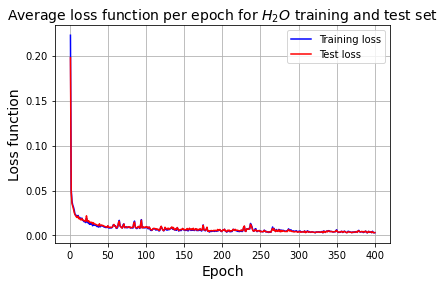

In [24]:
x = np.arange(1,nepochs+1)
# plt.plot(x[200:600],train_loss[200:600],'blue',label = 'Training loss')
# plt.plot(x[200:600],test_loss[200:600],'red',label = 'Test loss')

plt.plot(x[:400],train_loss[:400],'blue',label = 'Training loss')
plt.plot(x[:400],test_loss[:400],'red',label = 'Test loss')


plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Loss function',fontsize=14)
plt.title('Average loss function per epoch for $H_2O$ training and test set',fontsize=14)
plt.grid()
plt.legend()
plt.savefig('loss_graph_H2O',bbox_inches='tight')
plt.show()

In [25]:
print(np.shape(outputs))

torch.Size([25])


In [26]:
x1, x2, x3 = test_set[10]
x1 = x1
print(x1)

output = net(x1, x2, x3)
print('output')
print(output)

tensor([  -4.5161,   -3.9995,   -5.1756,   -3.9153,  -10.4564,  -55.5737,
          -4.3034,   -6.2949,   -2.3746, -507.3092,   -8.8254, -269.3573,
          -2.3854, -196.1882,   -2.3572, -143.2192,   -2.7678,  -40.5771,
          -3.3184,  -11.2665])
output
tensor([-0.4650], grad_fn=<ViewBackward>)


In [27]:
prediction = np.zeros(100)
for i in range(100):
    x1,x2,x3 = test_set[i]
    prediction[i] = net(x1, x2, x3)#[0]


In [28]:
print(prediction)


[-0.42604542 -0.43418038 -0.15118572 -0.31769645 -0.35961902 -0.01564322
  0.02764952  0.20080097  0.11060886  0.11521032 -0.46502477 -0.34780219
 -0.26343703 -0.43510413 -0.43951011 -0.04621547 -0.04857902  0.0695684
 -0.22981289 -0.48920506  0.49026838  0.04740983 -0.10733855  0.07519563
 -0.4293384   0.00969642 -0.44264609  0.06996229 -0.35209811  0.18484049
  0.41726473  0.20929235  0.28769088 -0.34514558 -0.04204257 -0.35300216
 -0.41326371 -0.25680935  0.16224992 -0.4219451  -0.22199968 -0.44393384
  0.64541876 -0.16648969 -0.12939724  0.47495341 -0.22555245  0.08305728
  0.06208731  0.16106752 -0.00463289 -0.17523874 -0.20218149 -0.17733398
 -0.1068269   0.03721975 -0.46985215  0.3010478  -0.23280331 -0.48272923
  0.01679234 -0.2748524   0.28917962 -0.44292784 -0.00902244  0.19349338
 -0.22982492  0.39547276  0.68447769 -0.28820837 -0.1150234  -0.00101949
  0.18829334  0.76542294  0.58225548  0.17942345 -0.10223925 -0.18251713
 -0.38673723 -0.42873412  0.01694992 -0.2644797   0.

In [29]:
print(np.shape(train_labels))
train_labels = np.array(train_labels)
print(np.mean(train_labels,axis=0))


torch.Size([900])
-2.6490954e-09


In [30]:
print(mean_lab)

-13813.419735561924


tensor(-0.5770, dtype=torch.float64)


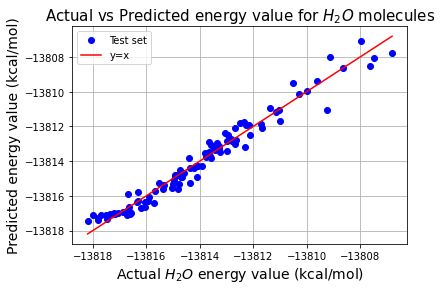

In [31]:
prediction = torch.tensor(prediction)

x = np.linspace(min(test_labels*var_lab+mean_lab), max(test_labels*var_lab+mean_lab))
print(min(torch.cat((test_labels,prediction),0)))
y = x
plt.plot(test_labels*var_lab+mean_lab,prediction*var_lab+mean_lab, 'o', color='blue', label = 'Test set')
plt.plot(x,y, color='red',label = 'y=x')
plt.grid()
#plt.xlim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction),0))])
#plt.ylim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction)))])
#plt.ylim([-13822,-13800])
#plt.ticklabel_format(axis="y", style="plain")
plt.ticklabel_format(useOffset=False, style='plain')
#plt.tick_params(axis='both',labelsize=14)
plt.xlabel('Actual $H_2O$ energy value (kcal/mol)',fontsize=14)
plt.ylabel('Predicted energy value (kcal/mol)',fontsize=14)
plt.title('Actual vs Predicted energy value for $H_2O$ molecules',fontsize=15)
plt.legend()
plt.savefig('predicted_energies_H2O',bbox_inches='tight')
plt.show()


In [32]:
print(type(prediction))

<class 'torch.Tensor'>


In [33]:
print('layer 1')
print('weights')
print(net.network1.fc1.weight)
print('biases')
print(net.network1.fc1.bias)

print('layer 2')
print('weights')
print(net.network1.fc2.weight)
print('biases')
print(net.network1.fc2.bias)

layer 1
weights
Parameter containing:
tensor([[ 2.6065e-01, -2.5736e-01,  2.0626e-01, -2.7914e-01, -2.1959e-01,
         -1.6672e-01,  3.2766e-01,  1.4297e-01,  4.9485e-02,  8.5347e-02,
          3.6335e-02, -2.1160e-01,  5.1101e-01, -4.4496e-03,  1.9313e-01,
          1.5726e-01,  3.1445e-01, -5.5190e-02,  3.4995e-01,  1.1511e-01],
        [ 9.4726e-01,  3.6160e-01,  1.6881e+00,  2.5591e-01, -1.5086e-02,
         -1.0619e-01,  4.2495e-01,  7.0953e-01,  3.1453e-01, -6.6357e-02,
         -2.4467e-02,  1.1275e-01,  1.9645e+00, -6.7396e-02,  3.5347e-01,
          7.3393e-02,  5.1611e-01,  1.6257e-01,  3.8818e-01,  2.3179e-01],
        [-7.5401e-01,  4.3655e-01, -8.9566e-01,  6.6575e-02, -1.1664e-01,
          9.3890e-02, -7.9665e-01, -4.2790e-01, -3.2203e-01,  3.4547e-02,
         -2.7067e-01,  6.4307e-02, -8.5870e-01, -1.5695e-01, -5.4232e-01,
         -1.1773e-01, -2.8487e-01, -2.0509e-01, -4.0915e-01,  3.2380e-02],
        [-3.0722e-02,  2.8992e-01, -5.0032e-01, -6.8952e-01,  2.5132e+0

In [34]:
heta    = [0.01,  4.,    3.202, 1.606, 2.404, 0.808] 
zeta    = [8.,  1.6, 3.2, 4.8, 6.4, 0. ]
Rs      = [0.8, 0.4, 0.2, 1.,  0.,  0.6]
lambdaa = [1., 1., 1., 1., 1., 1.]

**<h2>Rotating test set molecules and checking performance**

**<h3>Rotation Matrix**

In [35]:
def random_rotation_matrix():
    theta = np.arccos(2*np.random.uniform(low = 0,high = 1)-1)
    phi = np.random.uniform(low = 0,high = 2*np.pi)
    u = np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
    theta = np.random.uniform(low = 0,high = 2*np.pi)
    A = np.zeros((3,3))
    A[0][0] = np.cos(theta) + (u[0]**2)*(1-np.cos(theta))
    A[0][1] = u[0]*u[1]*(1-np.cos(theta)) - u[2]*np.sin(theta)
    A[0][2] = u[0]*u[2]*(1-np.cos(theta)) + u[1]*np.sin(theta)
    A[1][0] = u[1]*u[0]*(1-np.cos(theta)) + u[2]*np.sin(theta)
    A[1][1] = np.cos(theta) + (u[1]**2)*(1-np.cos(theta))
    A[1][2] = u[1]*u[2]*(1-np.cos(theta)) - u[0]*np.sin(theta)
    A[2][0] = u[2]*u[0]*(1-np.cos(theta)) - u[1]*np.sin(theta)
    A[2][1] = u[2]*u[1]*(1-np.cos(theta)) + u[0]*np.sin(theta)
    A[2][2] = np.cos(theta) + (u[2]**2)*(1-np.cos(theta))
    return A

In [36]:
def rotate_data(A,data):
    data = np.array(data)
    m = np.shape(data)[1]
    for i in range(m):
        data[:,i] = np.matmul(A,data[:,i])
    return data

In [37]:
rotated_molec_coord = np.zeros((np.shape(coordinates)))
for i in range(data_size):
    coord = coordinates[N*i:N*(i+1),:]
    coord = np.transpose(coord)
    A = random_rotation_matrix()
    rotated_molec_coord[N*i:N*(i+1),:] = np.transpose(rotate_data(A,coord))


**<h3> Computing symmetry functions for rotated test set**

In [38]:
G_rot = np.zeros((len(coordinates), number_of_features))  # we have 3000x2 features (2 symm funcs for ech of the 3000 atoms in the dataset)
N=3
for i in range(data_size):
    coord = rotated_molec_coord[N*i:N*(i+1),:]
    Dp    = pairwise_distances(coord)
    for j in range(0,number_of_features,2):
        G_rot[N*i:N*(i+1),j]   = radial_BP_symm_func(Dp,N,heta[j],Rs[j]) 
        G_rot[N*i:N*(i+1),j+1] = angular_BP_symm_func(coord,Dp,N,heta[j],Rs[j],lambdaa[j],zeta[j])
    
# Computing variance and mean on the training data only!
G_rot_train = G_rot[:training_set_size,:]
var  = np.var(G_rot_train,axis=0)
mean = np.mean(G_rot_train,axis=0)

G_rot_norm = np.zeros((len(coordinates), number_of_features))
# normalize all data (training and test), using training set mean and variance
for i in range(np.shape(G_rot)[0]):
    for j in range(np.shape(G_rot)[1]):
        G_rot_norm[i,j] = (G_rot[i,j]-mean[j])/var[j]   


data_set_rot = np.vsplit(G_rot_norm,data_size)     # Going from a (3000,2) np.array to a (1000,3,2) list
#data_set = np.random.permutation(training_set)
data_set_rot = torch.FloatTensor(data_set_rot)          # Going from a (1000,3,2) list to a a (1000,3,2) tensor

    
    
# Splitting the dataset into training and test set
training_set_rot         = data_set_rot[:training_set_size]
test_set_rot             = data_set_rot[training_set_size:]


1.287083627615273
0.9702538815523232
0.9290961788883947


IndexError: list index out of range

In [39]:
print(np.shape(G_rot))

(3000, 20)


In [40]:
prediction_rotated = np.zeros(100)
for i in range(100):
    x1,x2,x3 = test_set_rot[i]
    prediction_rotated[i] = net(x1, x2, x3)#[0]


prediction_rotated = torch.tensor(prediction_rotated)

x = np.linspace(min(test_labels*var_lab+mean_lab), max(test_labels*var_lab+mean_lab))
print(min(torch.cat((test_labels,prediction_rotated),0)))
y = x
plt.plot(test_labels*var_lab+mean_lab,prediction*var_lab+mean_lab, 'o', color='blue', label = 'rotated test set',markersize=8)
plt.plot(test_labels*var_lab+mean_lab,prediction_rotated*var_lab+mean_lab, '*', color='yellow', label = 'Test set')

plt.plot(x,y, color='red',label = 'y=x')
plt.grid()
#plt.xlim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction),0))])
#plt.ylim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction)))])
#plt.ylim([-13822,-13800])
#plt.ticklabel_format(axis="y", style="plain")
plt.ticklabel_format(useOffset=False, style='plain')
#plt.tick_params(axis='both',labelsize=14)
plt.xlabel('Actual $H_2O$ energy value (kcal/mol)',fontsize=14)
plt.ylabel('Predicted energy value (kcal/mol)',fontsize=14)
plt.title('Actual vs Predicted energy value for rotated $H_2O$ molecules',fontsize=15)
plt.legend()
plt.savefig('rotated_predicted_energies_H2O',bbox_inches='tight')
plt.show()


NameError: name 'test_set_rot' is not defined